Age_Group
Neonates (0–1 mo)          8
Early Infancy (1–5 mo)    33
Late Infancy (6–11 mo)    29
Toddlers (1–2 yr)         22
Preschoolers (3–5 yr)     10
School-age (6–11 yr)      15
Adolescents (12–17 yr)    10
Name: count, dtype: int64

✅ Total analyzed pediatric subjects: 127

Processing MI and FNN curves for Neonates (0–1 mo) (n=8)


Neonates (0–1 mo): 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]



Processing MI and FNN curves for Early Infancy (1–5 mo) (n=33)


Early Infancy (1–5 mo): 100%|██████████| 33/33 [00:43<00:00,  1.31s/it]



Processing MI and FNN curves for Late Infancy (6–11 mo) (n=29)


Late Infancy (6–11 mo): 100%|██████████| 29/29 [00:43<00:00,  1.52s/it]



Processing MI and FNN curves for Toddlers (1–2 yr) (n=22)


Toddlers (1–2 yr): 100%|██████████| 22/22 [00:28<00:00,  1.31s/it]



Processing MI and FNN curves for Preschoolers (3–5 yr) (n=10)


Preschoolers (3–5 yr): 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]



Processing MI and FNN curves for School-age (6–11 yr) (n=15)


School-age (6–11 yr): 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]



Processing MI and FNN curves for Adolescents (12–17 yr) (n=10)


Adolescents (12–17 yr): 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


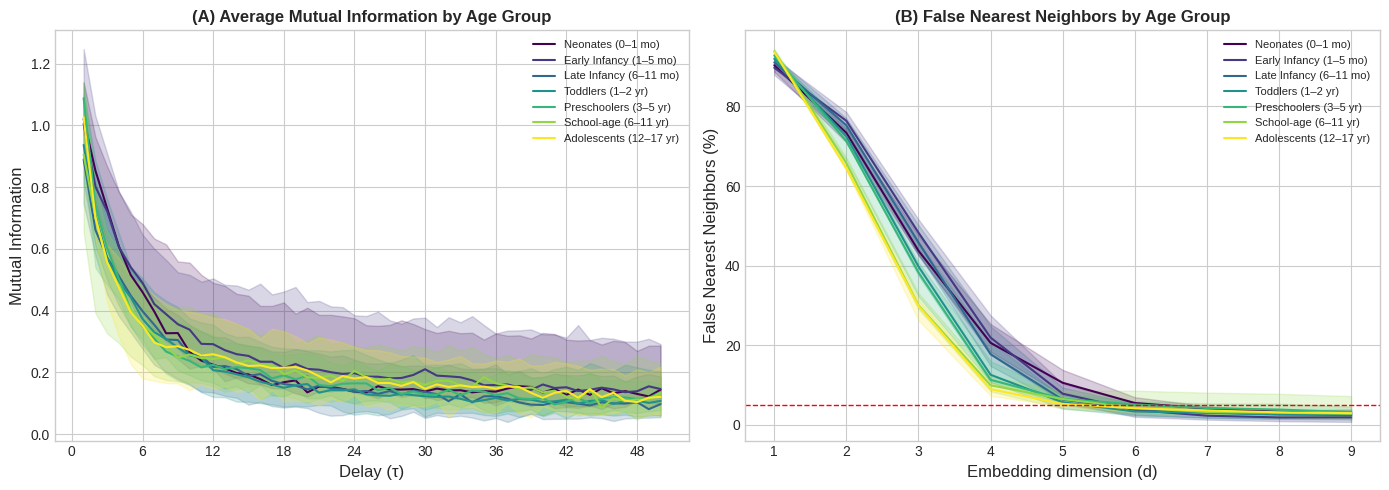


✅ Final summary (consistent with pediatric dataset and Figure S1):
                    Age Group  n (analyzed)
0           Neonates (0–1 mo)             8
1      Early Infancy (1–5 mo)            33
2      Late Infancy (6–11 mo)            29
3           Toddlers (1–2 yr)            22
4       Preschoolers (3–5 yr)            10
5        School-age (6–11 yr)            15
6      Adolescents (12–17 yr)            10
Total                   Total           127


In [16]:
# ============================================================
# Topological Data Analysis (TDA) – HRV Pediatric Embedding Estimation
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import MaxNLocator

# ============================================================
# 1️⃣ Load metadata and filter pediatric subset (<18 years)
# ============================================================

def assign_age_group(age):
    """WHO-based developmental stages"""
    if pd.isna(age):
        return "Unknown"
    elif 0 <= age < 1/12:
        return "Neonates (0–1 mo)"
    elif 1/12 <= age < 6/12:
        return "Early Infancy (1–5 mo)"
    elif 6/12 <= age < 1.0:
        return "Late Infancy (6–11 mo)"
    elif 1.0 <= age < 3.0:
        return "Toddlers (1–2 yr)"
    elif 3.0 <= age < 6.0:
        return "Preschoolers (3–5 yr)"
    elif 6.0 <= age < 12.0:
        return "School-age (6–11 yr)"
    elif 12.0 <= age < 17.0:
        return "Adolescents (12–17 yr)"
    else:
        return "Excluded"

# --- Load metadata ---
base_path = Path("/content/drive/MyDrive/Paper_TDA_HRV/rr_data/rr-interval-time-series-from-healthy-subjects-1.0.0")
df_info = pd.read_csv("/content/drive/MyDrive/Paper_TDA_HRV/patient-info.csv")

# --- Filter pediatric participants only ---
df_info = df_info[df_info["Age (years)"] < 18.0].copy()
df_info["Age_Group"] = df_info["Age (years)"].apply(assign_age_group)

print(f"✅ Pediatric subset loaded: {len(df_info)} participants")

# ============================================================
# 2️⃣ Validate file availability and group segmentation
# ============================================================

available_files = {f.stem for f in base_path.glob("*.txt")}
df_info["Valid_File"] = df_info["File"].apply(lambda x: f"{int(x):03d}" in available_files)
df_valid = df_info[df_info["Valid_File"] == True].copy()

group_order = [
    "Neonates (0–1 mo)", "Early Infancy (1–5 mo)", "Late Infancy (6–11 mo)",
    "Toddlers (1–2 yr)", "Preschoolers (3–5 yr)",
    "School-age (6–11 yr)", "Adolescents (12–17 yr)"
]

group_counts = df_valid["Age_Group"].value_counts().reindex(group_order).fillna(0).astype(int)
#print("\n📊 Subjects per group (after filtering and validation):")
print(group_counts)
print(f"\n✅ Total analyzed pediatric subjects: {group_counts.sum()}")

# ============================================================
# 3️⃣ Define helper functions
# ============================================================

def load_rr_series(file_path, N_sample=3000):
    rr = pd.read_csv(file_path, header=None).iloc[:, 0]
    rr = pd.to_numeric(rr, errors="coerce").dropna().values
    rr = rr[:N_sample] if len(rr) > N_sample else rr
    rr = (rr - np.mean(rr)) / np.std(rr)
    return rr

def mutual_information_delay(series, max_tau=50):
    taus = np.arange(1, max_tau + 1)
    mi_vals = []
    for t in taus:
        X = series[:-t].reshape(-1, 1)
        y = series[t:]
        mi_val = mutual_info_regression(X, y, random_state=1)
        mi_vals.append(mi_val[0])
    return taus, np.array(mi_vals)

def false_nearest_neighbors(ts, tau, dims, Rtol=10., Atol=2.):
    ts = np.asarray(ts)
    fnn_perc = []
    for d in dims:
        N = len(ts) - (d + 1) * tau
        if N <= 0:
            fnn_perc.append(np.nan)
            continue
        Xd = np.column_stack([ts[i:N+i] for i in range(0, d * tau, tau)])
        Xd1 = np.column_stack([ts[i:N+i] for i in range(0, (d + 1) * tau, tau)])
        nn = NearestNeighbors(n_neighbors=2).fit(Xd)
        dist, idx = nn.kneighbors(Xd)
        dist_d = dist[:, 1]
        dist_d1 = np.abs(Xd1[np.arange(N), -1] - Xd1[idx[:, 1], -1])
        R = dist_d1 / dist_d
        A = dist_d1 / np.std(ts)
        fnn = np.mean((R > Rtol) | (A > Atol)) * 100
        fnn_perc.append(fnn)
    return np.array(fnn_perc)

# ============================================================
# 4️⃣ Compute MI and FNN curves per developmental group
# ============================================================

max_tau = 50
dims = np.arange(1, 10)
N_sample = 3000
tau_fixed = 10

group_mi, group_fnn = {}, {}

for grupo in group_order:
    df_g = df_valid[df_valid["Age_Group"] == grupo]
    if df_g.empty:
        continue

    all_mi, all_fnn = [], []

    print(f"\nProcessing MI and FNN curves for {grupo} (n={len(df_g)})")
    for _, row in tqdm(df_g.iterrows(), total=len(df_g), desc=grupo):
        file_path = base_path / f"{int(row['File']):03d}.txt"
        if not file_path.exists():
            continue
        serie = load_rr_series(file_path, N_sample=N_sample)

        taus, mi_curve = mutual_information_delay(serie, max_tau=max_tau)
        all_mi.append(mi_curve)

        fnn_curve = false_nearest_neighbors(serie, tau=tau_fixed, dims=dims)
        all_fnn.append(fnn_curve)

    # Group-level median and IQR
    if all_mi:
        all_mi = np.vstack(all_mi)
        group_mi[grupo] = {
            "taus": taus,
            "median": np.nanmedian(all_mi, axis=0),
            "p25": np.nanpercentile(all_mi, 25, axis=0),
            "p75": np.nanpercentile(all_mi, 75, axis=0),
        }
    if all_fnn:
        all_fnn = np.vstack(all_fnn)
        group_fnn[grupo] = {
            "dims": dims,
            "median": np.nanmedian(all_fnn, axis=0),
            "p25": np.nanpercentile(all_fnn, 25, axis=0),
            "p75": np.nanpercentile(all_fnn, 75, axis=0),
        }

# ============================================================
# 5️⃣ Plot Supplementary Figure S1 (PLOS-style)
# ============================================================

plt.style.use("seaborn-v0_8-whitegrid")
colors = plt.cm.viridis(np.linspace(0, 1, len(group_mi)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax1, ax2 = axes

# --- Panel (A): Mutual Information ---
for color, (grupo, data) in zip(colors, group_mi.items()):
    ax1.plot(data["taus"], data["median"], color=color, label=grupo)
    ax1.fill_between(data["taus"], data["p25"], data["p75"], color=color, alpha=0.2)
ax1.set_xlabel('Delay (τ)', fontsize=12)
ax1.set_ylabel('Mutual Information', fontsize=12)
ax1.set_title('(A) Average Mutual Information by Age Group', fontsize=12, weight='bold')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(fontsize=8, loc='upper right')

# --- Panel (B): False Nearest Neighbors ---
for color, (grupo, data) in zip(colors, group_fnn.items()):
    ax2.plot(data["dims"], data["median"], color=color, label=grupo)
    ax2.fill_between(data["dims"], data["p25"], data["p75"], color=color, alpha=0.2)
ax2.axhline(5, color='r', linestyle='--', linewidth=1)
ax2.set_xlabel('Embedding dimension (d)', fontsize=12)
ax2.set_ylabel('False Nearest Neighbors (%)', fontsize=12)
ax2.set_title('(B) False Nearest Neighbors by Age Group', fontsize=12, weight='bold')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.savefig("FigS1_MI_FNN_by_agegroup_pediatric.png", dpi=400, bbox_inches='tight')
plt.savefig("FigS1_MI_FNN_by_agegroup_pediatric.pdf", dpi=400, bbox_inches='tight')
plt.show()

# ============================================================
# 6️⃣ Final summary table
# ============================================================

summary = pd.DataFrame({
    "Age Group": group_order,
    "n (analyzed)": [group_counts[g] for g in group_order],
})
summary.loc["Total"] = ["Total", summary["n (analyzed)"].sum()]

print("\n✅ Final summary (consistent with pediatric dataset and Figure S1):")
print(summary)


In [17]:
# ============================================================
# 7️⃣ Compute median and IQR of τ_opt and d_opt per group
# ============================================================

from scipy.signal import argrelextrema

def compute_tau_d_opt(series, max_tau=50, dims=np.arange(1, 8), Rtol=10., Atol=2.):
    taus, mi_curve = mutual_information_delay(series, max_tau=max_tau)
    # --- τ_opt = first local minimum of MI ---
    minima = argrelextrema(mi_curve, np.less)[0]
    tau_opt = taus[minima[0]] if len(minima) > 0 else taus[np.argmin(mi_curve)]

    # --- d_opt from FNN ---
    fnn_curve = false_nearest_neighbors(series, tau=tau_fixed, dims=dims, Rtol=Rtol, Atol=Atol)
    d_opt = dims[np.where(fnn_curve < 5)[0][0]] if np.any(fnn_curve < 5) else dims[-1]

    return tau_opt, d_opt

tau_stats = []
dims = np.arange(1, 8)

for grupo in group_order:
    df_g = df_valid[df_valid["Age_Group"] == grupo]
    if df_g.empty:
        continue

    tau_list, d_list = [], []
    for _, row in tqdm(df_g.iterrows(), total=len(df_g), desc=f"τ,d estimation - {grupo}"):
        file_path = base_path / f"{int(row['File']):03d}.txt"
        if not file_path.exists():
            continue
        serie = load_rr_series(file_path, N_sample=N_sample)
        tau_opt, d_opt = compute_tau_d_opt(serie, max_tau=max_tau, dims=dims)
        tau_list.append(tau_opt)
        d_list.append(d_opt)

    if len(tau_list) > 0:
        tau_median = np.median(tau_list)
        tau_iqr = (np.percentile(tau_list, 25), np.percentile(tau_list, 75))
        d_median = np.median(d_list)
        d_iqr = (np.percentile(d_list, 25), np.percentile(d_list, 75))
        tau_stats.append({
            "Age Group": grupo,
            "n (analyzed)": len(df_g),
            "τ_median": tau_median,
            "τ_IQR": f"({int(tau_iqr[0])}–{int(tau_iqr[1])})",
            "d_median": d_median,
            "d_IQR": f"({int(d_iqr[0])}–{int(d_iqr[1])})"
        })

# Create DataFrame
df_tau_stats = pd.DataFrame(tau_stats)
df_tau_stats.loc[len(df_tau_stats)] = {
    "Age Group": "Total",
    "n (analyzed)": int(df_tau_stats["n (analyzed)"].sum()),
    "τ_median": "--",
    "τ_IQR": "--",
    "d_median": "--",
    "d_IQR": "--"
}

print("\n✅ Final summary of optimal embedding parameters (pediatric subset):")
print(df_tau_stats)

# Export CSV and LaTeX version
df_tau_stats.to_csv("embedding_parameters_pediatric_summary.csv", index=False)

# Generate LaTeX table
latex_params = "\\begin{table}[htbp]\n\\centering\n"
latex_params += "\\caption{\\textbf{Median optimal embedding parameters per developmental age group (pediatric subset, $n=127$).}}\n"
latex_params += "\\label{tab:supp_embedding_params_pediatric}\n"
latex_params += "\\begin{tabular}{lccccc}\n\\toprule\n"
latex_params += "\\textbf{Age Group} & \\textbf{n} & $\\boldsymbol{\\tau}_\\mathrm{opt}$ & \\textbf{IQR} & $\\boldsymbol{d}_\\mathrm{opt}$ & \\textbf{IQR} \\\\\n\\midrule\n"
for _, r in df_tau_stats.iterrows():
    latex_params += f"{r['Age Group']} & {int(r['n (analyzed)'])} & {r['τ_median']} & {r['τ_IQR']} & {r['d_median']} & {r['d_IQR']} \\\\\n"
latex_params += "\\bottomrule\n\\end{tabular}\n\\end{table}"

with open("embedding_parameters_pediatric_summary.tex", "w") as f:
    f.write(latex_params)

print("\nLaTeX table saved as: embedding_parameters_pediatric_summary.tex")


τ,d estimation - Adolescents (12–17 yr): 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


✅ Final summary of optimal embedding parameters (pediatric subset):
                Age Group  n (analyzed) τ_median   τ_IQR d_median  d_IQR
0       Neonates (0–1 mo)             8     11.0  (8–14)      7.0  (6–7)
1  Early Infancy (1–5 mo)            33     11.0  (9–12)      6.0  (6–7)
2  Late Infancy (6–11 mo)            29     12.0  (9–14)      6.0  (6–7)
3       Toddlers (1–2 yr)            22     11.0  (8–13)      6.0  (5–6)
4   Preschoolers (3–5 yr)            10      9.0  (6–11)      6.5  (6–7)
5    School-age (6–11 yr)            15      9.0  (6–11)      6.0  (5–7)
6  Adolescents (12–17 yr)            10      7.5   (5–9)      6.0  (5–6)
7                   Total           127       --      --       --     --

LaTeX table saved as: embedding_parameters_pediatric_summary.tex



Fig S2 — Processing Neonates (0–1 mo) (n=8)


Neonates (0–1 mo): 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]



Fig S2 — Processing Early Infancy (1–5 mo) (n=33)


Early Infancy (1–5 mo): 100%|██████████| 33/33 [00:21<00:00,  1.57it/s]



Fig S2 — Processing Late Infancy (6–11 mo) (n=29)


Late Infancy (6–11 mo): 100%|██████████| 29/29 [00:19<00:00,  1.47it/s]



Fig S2 — Processing Toddlers (1–2 yr) (n=22)


Toddlers (1–2 yr): 100%|██████████| 22/22 [00:14<00:00,  1.50it/s]



Fig S2 — Processing Preschoolers (3–5 yr) (n=10)


Preschoolers (3–5 yr): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]



Fig S2 — Processing School-age (6–11 yr) (n=15)


School-age (6–11 yr): 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Fig S2 — Processing Adolescents (12–17 yr) (n=10)


Adolescents (12–17 yr): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]



✅ Fig S2 — Summary of d* estimates by method (FNN vs. Cao):
                Age Group    n d*_FNN_median d*_FNN_IQR d*_Cao_median  \
0       Neonates (0–1 mo)    8             7      (6–7)             9   
1  Early Infancy (1–5 mo)   33             6      (6–7)             9   
2  Late Infancy (6–11 mo)   29             6      (6–7)             9   
3       Toddlers (1–2 yr)   22             6      (5–6)             9   
4   Preschoolers (3–5 yr)   10             6      (6–9)             9   
5    School-age (6–11 yr)   15             6      (5–9)             9   
6  Adolescents (12–17 yr)   10             6      (5–6)             9   
7                   Total  127            --         --            --   

  d*_Cao_IQR  
0      (8–9)  
1      (2–9)  
2      (8–9)  
3      (8–9)  
4      (3–9)  
5      (9–9)  
6      (1–9)  
7         --  


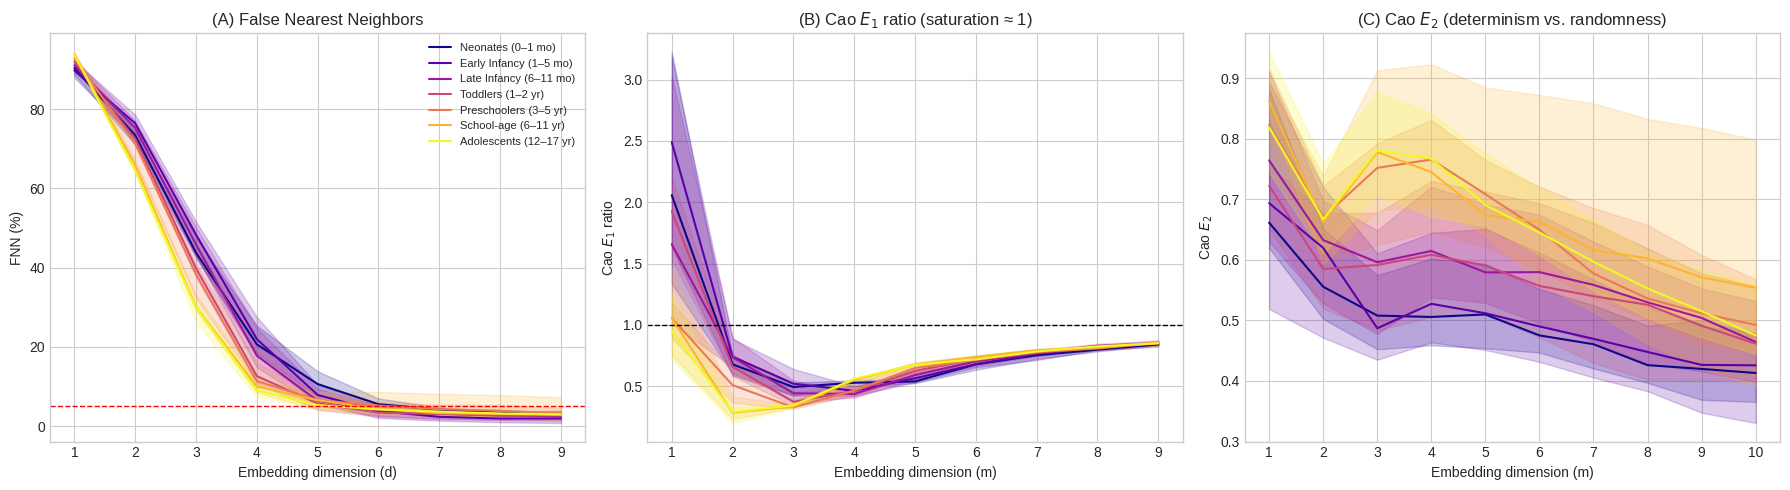

In [18]:
# ============================================================
# Figure S2 — FNN vs. Cao's Method (E1, E2) on pediatric subset
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import MaxNLocator
import warnings

# ----------------------------------------------
# Fallbacks si no están en el entorno actual:
# ----------------------------------------------
try:
    df_valid
except NameError:
    raise RuntimeError("df_valid no existe. Ejecuta primero el script que filtra el subset pediátrico (n=127).")

try:
    base_path
except NameError:
    base_path = Path("/content/drive/MyDrive/Paper_TDA_HRV/rr_data/rr-interval-time-series-from-healthy-subjects-1.0.0")

try:
    group_order
except NameError:
    group_order = [
        "Neonates (0–1 mo)", "Early Infancy (1–5 mo)", "Late Infancy (6–11 mo)",
        "Toddlers (1–2 yr)", "Preschoolers (3–5 yr)",
        "School-age (6–11 yr)", "Adolescents (12–17 yr)"
    ]

try:
    N_sample
except NameError:
    N_sample = 3000

try:
    tau_fixed
except NameError:
    tau_fixed = 10  # τ = 10 beats (global, como en el paper)

# ----------------------------------------------
# Utilidades
# ----------------------------------------------
def load_rr_series(file_path, N_sample=3000):
    rr = pd.read_csv(file_path, header=None).iloc[:, 0]
    rr = pd.to_numeric(rr, errors="coerce").dropna().values
    rr = rr[:N_sample] if len(rr) > N_sample else rr
    rr = (rr - np.mean(rr)) / np.std(rr)
    return rr

def false_nearest_neighbors(ts, tau, dims, Rtol=10., Atol=2.):
    """FNN (%) por dimensión d usando NN más cercano en R^d."""
    ts = np.asarray(ts)
    fnn_perc = []
    for d in dims:
        N = len(ts) - (d + 1) * tau
        if N <= 0:
            fnn_perc.append(np.nan); continue
        Xd  = np.column_stack([ts[i:N+i] for i in range(0, d * tau, tau)])
        Xd1 = np.column_stack([ts[i:N+i] for i in range(0, (d + 1) * tau, tau)])
        nn = NearestNeighbors(n_neighbors=2).fit(Xd)
        dist, idx = nn.kneighbors(Xd)
        dist_d  = dist[:, 1]
        dist_d1 = np.abs(Xd1[np.arange(N), -1] - Xd1[idx[:, 1], -1])
        R = dist_d1 / dist_d
        A = dist_d1 / np.std(ts)
        fnn = np.mean((R > Rtol) | (A > Atol)) * 100
        fnn_perc.append(fnn)
    return np.array(fnn_perc)

def cao_e1_e2(ts, tau, m_max=10):
    """
    Implementación práctica del método de Cao.
    Devuelve:
      - e1_ratio[m]: E1(m+1)/E1(m) ~ 1 => saturación (dim suficiente)
      - e2[m]: para distinguir determinista vs. aleatorio
    Notas:
      E1_raw(m) = mean( |x[i+m*tau] - x[j+m*tau]| / ||Y_i^m - Y_j^m|| ), j = NN en R^m
      e1_ratio(m) = E1_raw(m+1) / E1_raw(m)
      E2(m) = mean( |x[i+m*tau] - x[j+m*tau]| )
    """
    ts = np.asarray(ts)
    e1_raw = []
    e2_vals = []
    for m in range(1, m_max+1):
        N = len(ts) - (m + 1) * tau
        if N <= 0:
            e1_raw.append(np.nan); e2_vals.append(np.nan); continue
        Ym  = np.column_stack([ts[i:N+i] for i in range(0, m * tau, tau)])            # R^m
        Ym1 = np.column_stack([ts[i:N+i] for i in range(0, (m + 1) * tau, tau)])      # R^(m+1)

        nn = NearestNeighbors(n_neighbors=2).fit(Ym)
        dist, idx = nn.kneighbors(Ym)
        dist_m  = dist[:, 1]                               # ||Y_i^m - Y_j^m||
        # Diferencia del componente "futuro" (m-ésimo retraso)
        num = np.abs(Ym1[np.arange(N), -1] - Ym1[idx[:, 1], -1])
        # E1_raw(m)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = np.where(dist_m > 0, num / dist_m, np.nan)
        e1_raw.append(np.nanmean(ratio))
        # E2(m)
        e2_vals.append(np.nanmean(num))
    e1_raw = np.array(e1_raw)
    e2_vals = np.array(e2_vals)
    # E1-ratio: E1(m+1)/E1(m) para m=1..m_max-1; último NaN
    e1_ratio = np.full_like(e1_raw, np.nan, dtype=float)
    for m in range(0, len(e1_raw)-1):
        if np.isfinite(e1_raw[m]) and np.isfinite(e1_raw[m+1]) and e1_raw[m] != 0:
            e1_ratio[m] = e1_raw[m+1] / e1_raw[m]
    return e1_ratio, e2_vals

def estimate_d_opt_fnn(fnn_curve, dims, thr=5.0):
    if np.any(np.isfinite(fnn_curve) & (fnn_curve < thr)):
        return dims[np.where(fnn_curve < thr)[0][0]]
    return dims[-1]

def estimate_d_opt_cao(e1_ratio, eps=0.01, k_consecutive=2):
    """
    Dimensión mínima m donde e1_ratio se estabiliza ~1.
    Criterio: |e1_ratio[m] - 1| < eps por al menos k_consecutive m consecutivos.
    """
    e1 = np.copy(e1_ratio)
    # Evitar NaN al final
    valid = np.where(np.isfinite(e1))[0]
    if len(valid) == 0:
        return np.nan
    for m in valid:
        window = e1[m:m+k_consecutive]
        if len(window) < k_consecutive:
            break
        if np.all(np.abs(window - 1.0) < eps):
            return m+1  # dimensiones empiezan en 1
    # Si no hay saturación clara, elegir el m más cercano a 1
    idx = np.nanargmin(np.abs(e1 - 1.0))
    return idx+1

# ----------------------------------------------
# Parámetros de figura / análisis
# ----------------------------------------------
dims = np.arange(1, 10)   # d = 1..9
m_max = 10                # Cao evaluado hasta m=10
eps_cao = 0.01            # margen de saturación para E1-ratio
k_consecutive = 2

# ----------------------------------------------
# Cómputo por grupo
# ----------------------------------------------
group_curves_fnn = {}
group_curves_e1  = {}
group_curves_e2  = {}
rows_summary = []

for grupo in group_order:
    df_g = df_valid[df_valid["Age_Group"] == grupo]
    if df_g.empty:
        continue

    all_fnn, all_e1, all_e2 = [], [], []
    dopt_fnn_list, dopt_cao_list = [], []

    print(f"\nFig S2 — Processing {grupo} (n={len(df_g)})")
    for _, row in tqdm(df_g.iterrows(), total=len(df_g), desc=grupo):
        fp = base_path / f"{int(row['File']):03d}.txt"
        if not fp.exists():
            continue
        ts = load_rr_series(fp, N_sample=N_sample)

        # FNN
        fnn_curve = false_nearest_neighbors(ts, tau=tau_fixed, dims=dims)
        d_fnn = estimate_d_opt_fnn(fnn_curve, dims, thr=5.0)

        # Cao (E1, E2)
        e1_ratio, e2_vals = cao_e1_e2(ts, tau=tau_fixed, m_max=m_max)
        d_cao = estimate_d_opt_cao(e1_ratio, eps=eps_cao, k_consecutive=k_consecutive)

        if np.all(~np.isfinite(fnn_curve)) or np.all(~np.isfinite(e1_ratio)):
            continue

        all_fnn.append(fnn_curve)
        all_e1.append(e1_ratio)
        all_e2.append(e2_vals)
        dopt_fnn_list.append(d_fnn)
        dopt_cao_list.append(d_cao)

    if len(all_fnn) == 0:
        warnings.warn(f"No valid curves for {grupo}")
        continue

    all_fnn = np.vstack(all_fnn)
    all_e1  = np.vstack(all_e1)
    all_e2  = np.vstack(all_e2)

    group_curves_fnn[grupo] = {
        "dims": dims,
        "median": np.nanmedian(all_fnn, axis=0),
        "p25": np.nanpercentile(all_fnn, 25, axis=0),
        "p75": np.nanpercentile(all_fnn, 75, axis=0),
    }
    group_curves_e1[grupo] = {
        "m": np.arange(1, m_max+1),
        "median": np.nanmedian(all_e1, axis=0),
        "p25": np.nanpercentile(all_e1, 25, axis=0),
        "p75": np.nanpercentile(all_e1, 75, axis=0),
    }
    group_curves_e2[grupo] = {
        "m": np.arange(1, m_max+1),
        "median": np.nanmedian(all_e2, axis=0),
        "p25": np.nanpercentile(all_e2, 25, axis=0),
        "p75": np.nanpercentile(all_e2, 75, axis=0),
    }

    # Resumen por grupo
    rows_summary.append({
        "Age Group": grupo,
        "n": len(dopt_fnn_list),
        "d*_FNN_median": int(np.nanmedian(dopt_fnn_list)),
        "d*_FNN_IQR": f"({int(np.nanpercentile(dopt_fnn_list,25))}–{int(np.nanpercentile(dopt_fnn_list,75))})",
        "d*_Cao_median": int(np.nanmedian(dopt_cao_list)),
        "d*_Cao_IQR": f"({int(np.nanpercentile(dopt_cao_list,25))}–{int(np.nanpercentile(dopt_cao_list,75))})",
    })

df_cao_fnn_summary = pd.DataFrame(rows_summary)
df_cao_fnn_summary.loc[len(df_cao_fnn_summary)] = {
    "Age Group": "Total",
    "n": int(df_cao_fnn_summary["n"].sum()),
    "d*_FNN_median": "--",
    "d*_FNN_IQR": "--",
    "d*_Cao_median": "--",
    "d*_Cao_IQR": "--",
}

print("\n✅ Fig S2 — Summary of d* estimates by method (FNN vs. Cao):")
print(df_cao_fnn_summary)

df_cao_fnn_summary.to_csv("FigS2_dopt_summary_FNN_vs_Cao.csv", index=False)

# ----------------------------------------------
# FIGURE S2 (A,B,C)
# ----------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
colors = plt.cm.plasma(np.linspace(0, 1, len(group_curves_fnn)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axA, axB, axC = axes

# (A) FNN vs d (mediana ± IQR)
for color, (grp, data) in zip(colors, group_curves_fnn.items()):
    axA.plot(data["dims"], data["median"], color=color, label=grp)
    axA.fill_between(data["dims"], data["p25"], data["p75"], color=color, alpha=0.2)
axA.axhline(5, color='r', linestyle='--', linewidth=1)
axA.set_xlabel('Embedding dimension (d)')
axA.set_ylabel('FNN (%)')
axA.set_title('(A) False Nearest Neighbors')
axA.xaxis.set_major_locator(MaxNLocator(integer=True))
axA.legend(fontsize=8, loc='upper right')

# (B) Cao E1-ratio(m) ~ 1 en saturación
for color, (grp, data) in zip(colors, group_curves_e1.items()):
    axB.plot(data["m"], data["median"], color=color, label=grp)
    axB.fill_between(data["m"], data["p25"], data["p75"], color=color, alpha=0.2)
axB.axhline(1.0, color='k', linestyle='--', linewidth=1)
axB.set_xlabel('Embedding dimension (m)')
axB.set_ylabel('Cao $E_1$ ratio')
axB.set_title('(B) Cao $E_1$ ratio (saturation ≈ 1)')
axB.xaxis.set_major_locator(MaxNLocator(integer=True))

# (C) Cao E2(m)
for color, (grp, data) in zip(colors, group_curves_e2.items()):
    axC.plot(data["m"], data["median"], color=color, label=grp)
    axC.fill_between(data["m"], data["p25"], data["p75"], color=color, alpha=0.2)
axC.set_xlabel('Embedding dimension (m)')
axC.set_ylabel('Cao $E_2$')
axC.set_title('(C) Cao $E_2$ (determinism vs. randomness)')
axC.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("FigS2_FNN_vs_Cao.png", dpi=400, bbox_inches='tight')
plt.savefig("FigS2_FNN_vs_Cao.pdf", dpi=400, bbox_inches='tight')
plt.show()


In [19]:
!pip install ripser
!pip install persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.3/827.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=edb3b0c340082f5c26d708a2534e5a9a96cb746e144e593d5f320d721bbae658
  Stored in directory: /root/.cache/pip/wheels/2a/fd/fe/f4b8fd82894e1d9e04040ef41dc5ae6eb7a8e9b0ef5a9402fe
Successfully built hopcroftkarp



Analyzing topological sensitivity for Adolescents (12–17 yr) (n=5)


Adolescents (12–17 yr): 100%|██████████| 5/5 [10:16<00:00, 123.22s/it]



Analyzing topological sensitivity for Early Infancy (1–5 mo) (n=5)


Early Infancy (1–5 mo): 100%|██████████| 5/5 [20:43<00:00, 248.66s/it]



Analyzing topological sensitivity for Excluded (n=2)


Excluded: 100%|██████████| 2/2 [03:25<00:00, 102.88s/it]



Analyzing topological sensitivity for Late Infancy (6–11 mo) (n=5)


Late Infancy (6–11 mo): 100%|██████████| 5/5 [21:18<00:00, 255.77s/it]



Analyzing topological sensitivity for Neonates (0–1 mo) (n=5)


Neonates (0–1 mo): 100%|██████████| 5/5 [21:18<00:00, 255.77s/it]



Analyzing topological sensitivity for Preschoolers (3–5 yr) (n=5)


Preschoolers (3–5 yr): 100%|██████████| 5/5 [12:36<00:00, 151.30s/it]



Analyzing topological sensitivity for School-age (6–11 yr) (n=5)


School-age (6–11 yr): 100%|██████████| 5/5 [13:56<00:00, 167.32s/it]



Analyzing topological sensitivity for Toddlers (1–2 yr) (n=5)


Toddlers (1–2 yr): 100%|██████████| 5/5 [12:58<00:00, 155.63s/it]


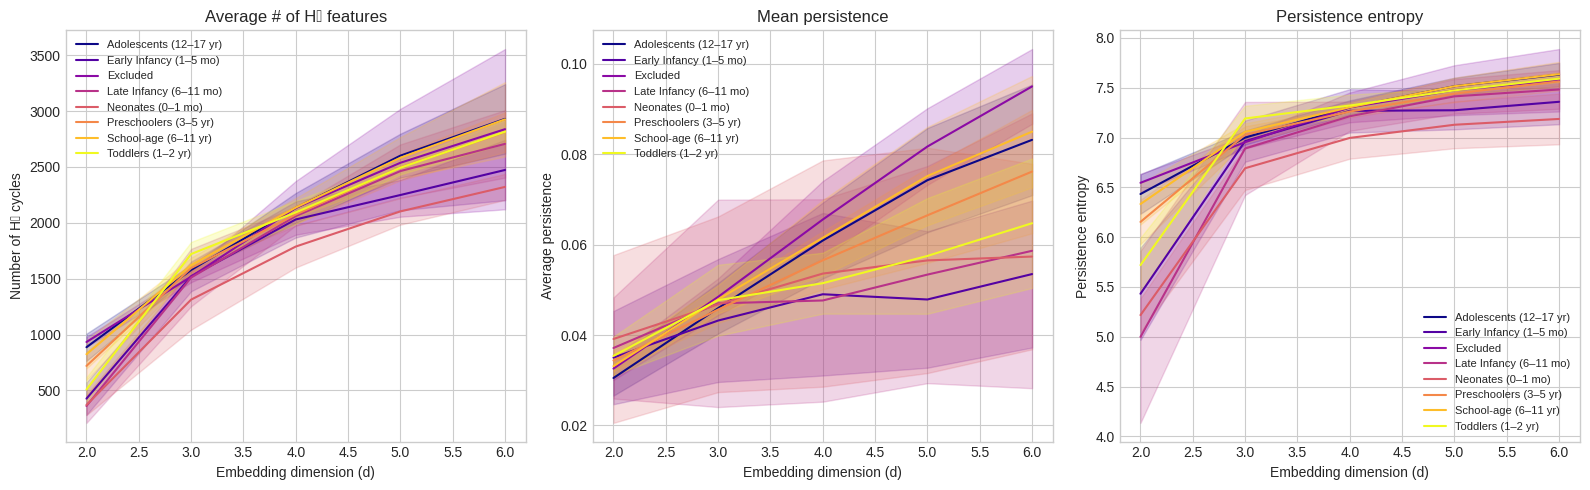

✅ Saved: FigS3_Topological_Sensitivity.png


In [20]:
# ============================================================
# Topological Sensitivity Analysis — Maletić et al. (2016)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from ripser import ripser
from persim import plot_diagrams
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from itertools import product
from pathlib import Path

# -------------------------------
# Configuración general
# -------------------------------
dims_eval = [2, 3, 4, 5, 6,7,8]
tau = 10
N_sample = 3000
max_representatives = 5  # sujetos por grupo para no sobrecargar

base_path = Path("/content/drive/MyDrive/Paper_TDA_HRV/rr_data/rr-interval-time-series-from-healthy-subjects-1.0.0")

# -------------------------------
# Utilidades
# -------------------------------
def load_rr_series(fp, N_sample=3000):
    x = pd.read_csv(fp, header=None).iloc[:, 0]
    x = pd.to_numeric(x, errors="coerce").dropna().values
    x = x[:N_sample] if len(x) > N_sample else x
    x = (x - np.mean(x)) / np.std(x)
    return x

def delay_embedding(ts, m, tau):
    N = len(ts) - (m - 1) * tau
    return np.column_stack([ts[i:N+i] for i in range(0, m * tau, tau)])

def compute_persistence_features(X):
    dgms = ripser(X, maxdim=1)['dgms']
    dgm1 = dgms[1] if len(dgms) > 1 else np.array([])
    if len(dgm1) == 0:
        return dict(num_h1=0, mean_pers=0, pers_entropy=0)
    pers = dgm1[:,1] - dgm1[:,0]
    pers = pers[pers > 0]
    p_norm = pers / np.sum(pers)
    pers_entropy = -np.sum(p_norm * np.log(p_norm))
    return dict(pers_entropy=pers_entropy)

# -------------------------------
# Ejecución principal
# -------------------------------
results = []
for group, subdf in df_valid.groupby("Age_Group"):
    subdf = subdf.sample(n=min(max_representatives, len(subdf)), random_state=42)
    print(f"\nAnalyzing topological sensitivity for {group} (n={len(subdf)})")
    for _, row in tqdm(subdf.iterrows(), total=len(subdf), desc=group):
        fp = base_path / f"{int(row['File']):03d}.txt"
        if not fp.exists():
            continue
        ts = load_rr_series(fp, N_sample=N_sample)
        for d in dims_eval:
            X = delay_embedding(ts, m=d, tau=tau)
            feats = compute_persistence_features(X)
            feats.update(dict(Age_Group=group, d=d, File=row['File']))
            results.append(feats)

df_sens = pd.DataFrame(results)

# -------------------------------
# Resumen estadístico por grupo
# -------------------------------
summary = (
    df_sens.groupby(["Age_Group", "d"])
    .agg(H1_entropy_mean=("pers_entropy", "mean"),
         H1_entropy_std=("pers_entropy", "std"))
    .reset_index()
)



In [27]:
summary.to_excel("Sensitivity.csv", index=False)

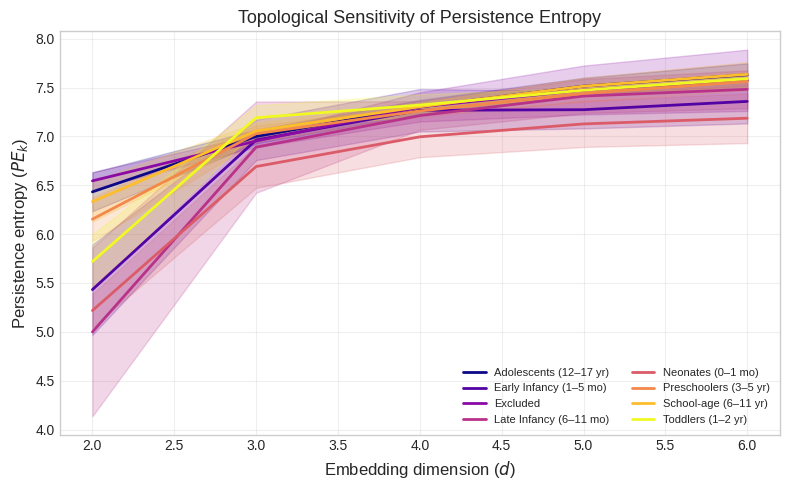

FigS3_PersistenceEntropy_Sensitivity.png


In [42]:
# ============================================================
# FIGURE S3 — Sensitivity of Persistence Entropy (PEₖ) to Embedding Dimension
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load summarized sensitivity dataset
# ------------------------------------------------------------
summary = pd.read_csv("Sensitivity.csv")

# Ensure column names match your file
summary.columns = [c.strip() for c in summary.columns]

# ------------------------------------------------------------
# 2. Figure — Persistence Entropy vs. Embedding Dimension
# ------------------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.cm.plasma(np.linspace(0, 1, summary["Age_Group"].nunique()))

for c, (grp, sub) in zip(colors, summary.groupby("Age_Group")):
    ax.plot(sub["d"], sub["H1_entropy_mean"], label=grp, color=c, lw=2)
    ax.fill_between(
        sub["d"],
        sub["H1_entropy_mean"] - sub["H1_entropy_std"],
        sub["H1_entropy_mean"] + sub["H1_entropy_std"],
        alpha=0.2, color=c
    )

# Axis labels and titlence entropy ($PE_{k}$)", fontsize=12)
ax.set_xlabel(r"Embedding dimension ($d$)", fontsize=12)
ax.set_ylabel(r"Persistence entropy ($PE_{k}$)", fontsize=12)

ax.set_title("Topological Sensitivity of Persistence Entropy", fontsize=13)

# Cosmetic adjustments
ax.legend(fontsize=8, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()

# Save and show
plt.savefig("FigS3_PersistenceEntropy_Sensitivity.png", dpi=400, bbox_inches="tight")
plt.show()

print("FigS3_PersistenceEntropy_Sensitivity.png")


In [29]:
!pip install scikit_posthocs